# Analysis of the experiments for the so called RADICAL-Pilot paper

In [2]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

In [3]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 12
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [4]:
sessions = pd.read_csv('data/sessions.csv', index_col=0)
pilots = pd.read_csv('data/pilots.csv', index_col=0)
units = pd.read_csv('data/units.csv', index_col=0)

In [12]:
sessions.loc[(sessions['nunit'] >= 8   ) & (sessions['nunit'] < 16  ), 'nunit_requested'] = 8
sessions.loc[(sessions['nunit'] >= 16  ) & (sessions['nunit'] < 32  ), 'nunit_requested'] = 16
sessions.loc[(sessions['nunit'] >= 32  ) & (sessions['nunit'] < 64  ), 'nunit_requested'] = 32
sessions.loc[(sessions['nunit'] >= 64  ) & (sessions['nunit'] < 128 ), 'nunit_requested'] = 64
sessions.loc[(sessions['nunit'] >= 128 ) & (sessions['nunit'] < 256 ), 'nunit_requested'] = 128
sessions.loc[(sessions['nunit'] >= 256 ) & (sessions['nunit'] < 512 ), 'nunit_requested'] = 256
sessions.loc[(sessions['nunit'] >= 512 ) & (sessions['nunit'] < 1024), 'nunit_requested'] = 512
sessions.loc[(sessions['nunit'] >= 1024) & (sessions['nunit'] < 2048), 'nunit_requested'] = 1024
sessions.loc[(sessions['nunit'] >= 2048) & (sessions['nunit'] < 4096), 'nunit_requested'] = 2048
sessions.loc[(sessions['nunit'] >= 4096) & (sessions['nunit'] < 8192), 'nunit_requested'] = 4096

sessions['nunit_rescheduled'] = sessions['nunit'] - sessions['nunit_requested']

In [14]:
ttc = sessions[
    ['npilot','TTC','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'TTC':{'TTC_mean':'mean','TTC_std':'std'}})
ttc.columns = ttc.columns.droplevel(0)
ttc = ttc.reset_index()

In [15]:
sessions

,P_LRMS_QUEUING,P_LRMS_RUNNING,P_LRMS_SUBMITTING,P_PMGR_QUEUING,P_PMGR_SCHEDULING,TTC,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,U_AGENT_SCHEDULING,...,experiment,nhost,npilot,npilot_active,nunit,nunit_done,nunit_failed,sid,nunit_requested,nunit_rescheduled
rp.session.radical.merzky.017192.0008,318.1477,801.3306,46.7645,0.0009,0.0013,1202.3098,758.9396,0.0338,1.9119,0.1128,...,exp1,1,1,1,128,128,0,rp.session.radical.merzky.017192.0008,128.0,0.0
rp.session.radical.merzky.017192.0009,150.8808,1101.2445,42.6271,0.0010,0.0009,1331.4133,760.2981,0.0647,4.6479,0.2350,...,exp1,1,1,1,256,256,0,rp.session.radical.merzky.017192.0009,256.0,0.0
rp.session.radical.merzky.017192.0011,708.0368,1001.1202,39.3594,0.0009,0.0007,1770.3468,766.6900,0.1279,12.1013,0.5488,...,exp1,1,1,1,512,512,0,rp.session.radical.merzky.017192.0011,512.0,0.0
rp.session.radical.merzky.017192.0012,306.6597,2302.2549,36.8443,0.0012,0.0010,2681.8011,796.8777,0.2576,37.1107,1.5640,...,exp1,1,1,1,1024,1024,0,rp.session.radical.merzky.017192.0012,1024.0,0.0
rp.session.radical.merzky.017192.0013,392.0895,4169.6879,35.6363,0.0009,0.0006,4601.6725,843.9420,0.5157,81.1673,3.9673,...,exp1,1,1,1,2048,2048,0,rp.session.radical.merzky.017192.0013,2048.0,0.0
rp.session.radical.merzky.017192.0014,1942.9586,6306.6429,36.3157,0.0009,0.0010,8289.6901,935.5481,1.0724,182.8162,19.2006,...,exp1,1,1,1,4096,4096,0,rp.session.radical.merzky.017192.0014,4096.0,0.0


In [16]:
pilots

,P_LRMS_QUEUING,P_LRMS_RUNNING,P_LRMS_SUBMITTING,P_PMGR_QUEUING,P_PMGR_SCHEDULING,experiment,hid,nunit,pid,sid
0,318.1477,801.3306,46.7645,0.0009,0.0013,exp1,stampede.tacc.utexas.edu,128,pilot.0000,rp.session.radical.merzky.017192.0008
1,150.8808,1101.2445,42.6271,0.0010,0.0009,exp1,stampede.tacc.utexas.edu,256,pilot.0000,rp.session.radical.merzky.017192.0009
2,708.0368,1001.1202,39.3594,0.0009,0.0007,exp1,stampede.tacc.utexas.edu,512,pilot.0000,rp.session.radical.merzky.017192.0011
3,306.6597,2302.2549,36.8443,0.0012,0.0010,exp1,stampede.tacc.utexas.edu,1024,pilot.0000,rp.session.radical.merzky.017192.0012
4,392.0895,4169.6879,35.6363,0.0009,0.0006,exp1,stampede.tacc.utexas.edu,2048,pilot.0000,rp.session.radical.merzky.017192.0013
5,1942.9586,6306.6429,36.3157,0.0009,0.0010,exp1,stampede.tacc.utexas.edu,4096,pilot.0000,rp.session.radical.merzky.017192.0014


In [17]:
units

,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,U_AGENT_SCHEDULING,U_UMGR_BINDING,U_UMGR_SCHEDULING,experiment,hid,pid,sid,uid
0,699.7349,0.0338,0.0015,0.0137,0.0196,0.0863,exp1,stampede.tacc.utexas.edu,pilot.0000,rp.session.radical.merzky.017192.0008,unit.000000
1,694.7092,0.0338,0.0118,0.0145,0.0196,0.0857,exp1,stampede.tacc.utexas.edu,pilot.0000,rp.session.radical.merzky.017192.0008,unit.000001
2,703.7295,0.0338,0.0215,0.0153,0.0196,0.0850,exp1,stampede.tacc.utexas.edu,pilot.0000,rp.session.radical.merzky.017192.0008,unit.000002
3,694.6897,0.0338,0.0310,0.0162,0.0196,0.0844,exp1,stampede.tacc.utexas.edu,pilot.0000,rp.session.radical.merzky.017192.0008,unit.000003
4,704.7138,0.0338,0.0411,0.0169,0.0196,0.0838,exp1,stampede.tacc.utexas.edu,pilot.0000,rp.session.radical.merzky.017192.0008,unit.000004
5,696.6752,0.0338,0.0503,0.0177,0.0196,0.0832,exp1,stampede.tacc.utexas.edu,pilot.0000,rp.session.radical.merzky.017192.0008,unit.000005
6,704.6959,0.0338,0.0598,0.0184,0.0196,0.0826,exp1,stampede.tacc.utexas.edu,pilot.0000,rp.session.radical.merzky.017192.0008,unit.000006
7,706.6898,0.0338,0.0688,0.0192,0.0196,0.0820,exp1,stampede.tacc.utexas.edu,pilot.0000,rp.session.radical.merzky.017192.0008,unit.000007
8,703.6687,0.0338,0.0785,0.0200,0.0196,0.0814,exp1,stampede.tacc.utexas.edu,pilot.0000,rp.session.radical.merzky.017192.0008,unit.000008
9,700.6455,0.0338,0.0879,0.0207,0.0196,0.0808,exp1,stampede.tacc.utexas.edu,pilot.0000,rp.session.radical.merzky.017192.0008,unit.000009


## Experiment 1

*   Use case: AMBER/CoCo ensembles for molecular sciences.
    *   Spatial heterogeneity (Hs): 0
    *   Temporal heterogeneity (Ht): 1
    *   Input/output dependency among tasks (D): 1
    *   Runtime communication among tasks (C): 1
*   workload:
    *   Number of stages: 2
    *   Number of iteration for each stage: 1-20
    *   Stage 1
        *   Number of tasks: 128-16384 (as specified in use case proposal)
        *   Number of cores per task: 1
        *   Number of input files: ??
        *   Number of output files: ??
    *   Stage 2
        *   Number of tasks: (n tasks Stage 1)/64-128
        *   Number of cores per task: 64-128 (limited by CoCo scalability)
        *   Number of input files: ??
        *   Number of output files: ??
*   Executables: Synapse emulator
*   Resources: Stampede, Titan

***NOTE 1***: the following is a parameter composition within the boundaries posed by the use case. It is likely the number of experiments will be reduced/aggregated.

***NOTE 2***: Walltime for each pilot is calculated as:
```
i * mean execution time of 3 task * number of generations
```
`i` is 2 by default and adjusted in case of failure.

### Experiment 1.a

*   Measure: concurrent 1-core tasks execution time (TTX)
*   Hs: 0
*   Ht: SD 25%
*   D: 0
*   C: 0

| N tasks | N core/task | N generations | N pilot | N core/pilot | Resource       |
|---------|-------------|---------------|---------|--------------|----------------|
| 128     | 1           | 1             | 1       | 128          | Stampede/Titan |
| 256     | 1           | 1             | 1       | 256          | Stampede/Titan |
| 512     | 1           | 1             | 1       | 512          | Stampede/Titan |
| 1024    | 1           | 1             | 1       | 1024         | Stampede/Titan |
| 2048    | 1           | 1             | 1       | 2048         | Stampede/Titan |
| 4096    | 1           | 1             | 1       | 4096         | Stampede/Titan |
| 8192    | 1           | 1             | 1       | 8192         | Stampede/Titan |
| 16384   | 1           | 1             | 1       | 16384        | Titan          |

,npilot,nunit_requested,TTC_mean,TTC_std
0,1,128.0,1202.3098,NaN
1,1,256.0,1331.4133,NaN
2,1,512.0,1770.3468,NaN
3,1,1024.0,2681.8011,NaN
4,1,2048.0,4601.6725,NaN
5,1,4096.0,8289.6901,NaN


,npilot,nunit_requested,TTX_std,TTX_mean
0,1,128.0,NaN,758.9396
1,1,256.0,NaN,760.2981
2,1,512.0,NaN,766.6900
3,1,1024.0,NaN,796.8777
4,1,2048.0,NaN,843.9420
5,1,4096.0,NaN,935.5481


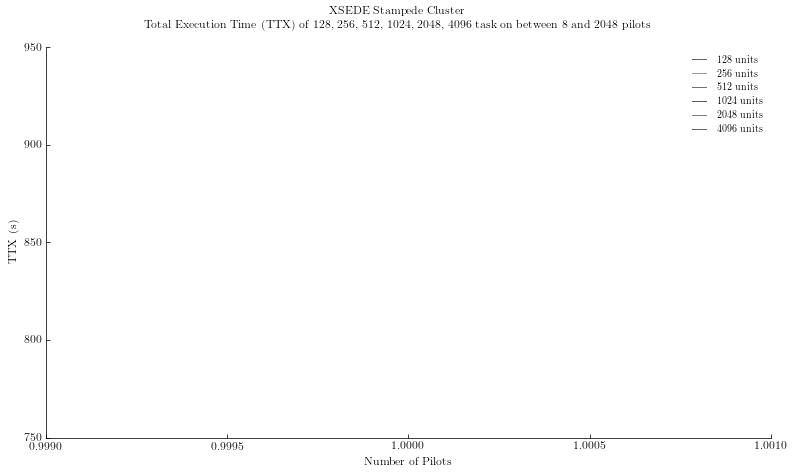

In [21]:
fig, ax = fig_setup()
title_head = 'XSEDE Stampede Cluster'
title_desc = 'Total Execution Time (TTX) of 128, 256, 512, 1024, 2048, 4096 task on 1 pilot with between 8 and 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

ttx = sessions[
    ['npilot','U_AGENT_EXECUTING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'U_AGENT_EXECUTING':{'TTX_mean':'mean','TTX_std':'std'}})
ttx.columns = ttx.columns.droplevel(0)
ttx = ttx.reset_index()

display(ttc)
display(ttx)

#display(ttc)
colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

nus = ttc['nunit_requested'].unique()
nus.sort()

for nu in nus:
    ttx.loc[ttx['nunit_requested']==nu].plot(x='npilot', y='TTX_mean', yerr='TTX_std', 
                                             label=str(int(nu))+' units',
                                             color=colors.pop(0),
                                             ax=ax)

# plt.axhline(43200, color='r', linestyle='dashed', linewidth=1, label='12 hours')

# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
# ax.set_xlim((2**2, 2**12))
ax.set_xlabel('Number of Pilots')
ax.set_ylabel('TTX (s)')

# plt.savefig('figures/osg_ttx_pilots.pdf', dpi=600, bbox_inches='tight')